In [ ]:
from google.colab import files
uploaded = files.upload(
)

Saving task4.csv to task4 (2).csv


sentiment,Irrelevant,Negative,Neutral,Positive
topic,,,,
AssassinsCreed,264,378,156,1446
Borderlands,240,426,600,1020
Cyberpunk2077,480,390,468,966
PlayStation5(PS5),396,456,516,942
RedDeadRedemption(RDR),210,306,816,930
CallOfDutyBlackopsColdWar,576,576,360,864
Hearthstone,228,528,708,834
Nvidia,90,522,870,816
Xbox(Xseries),750,378,414,792


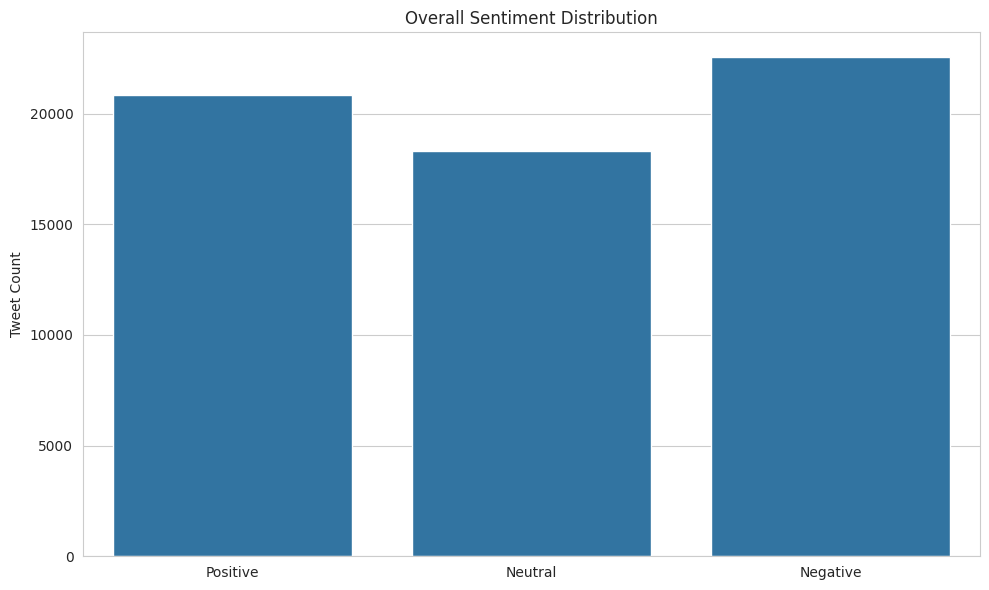

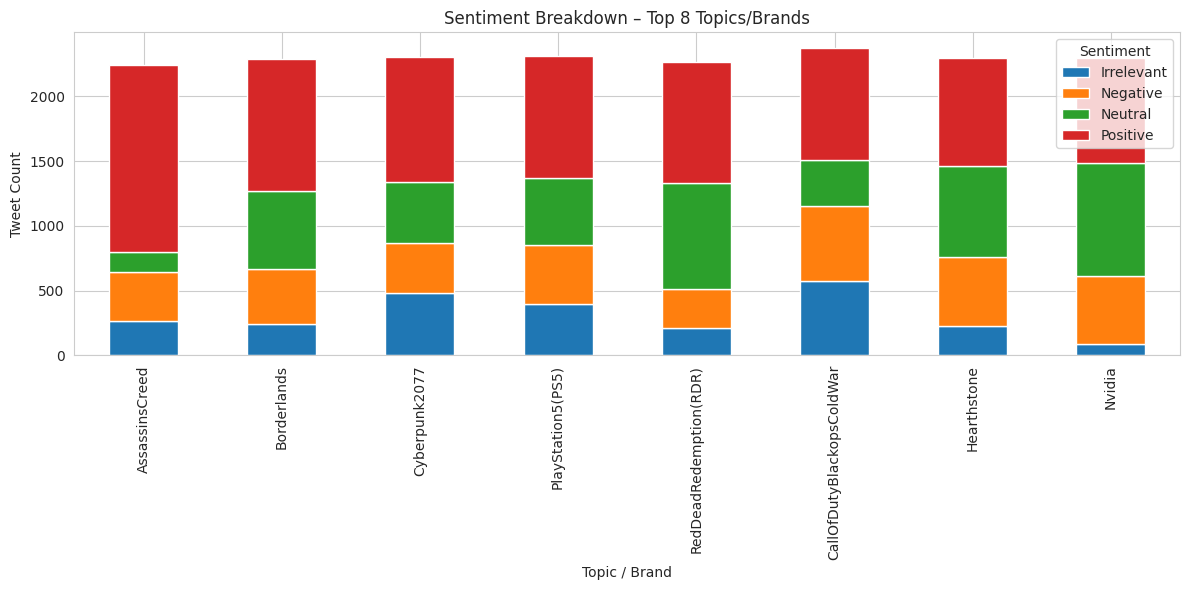

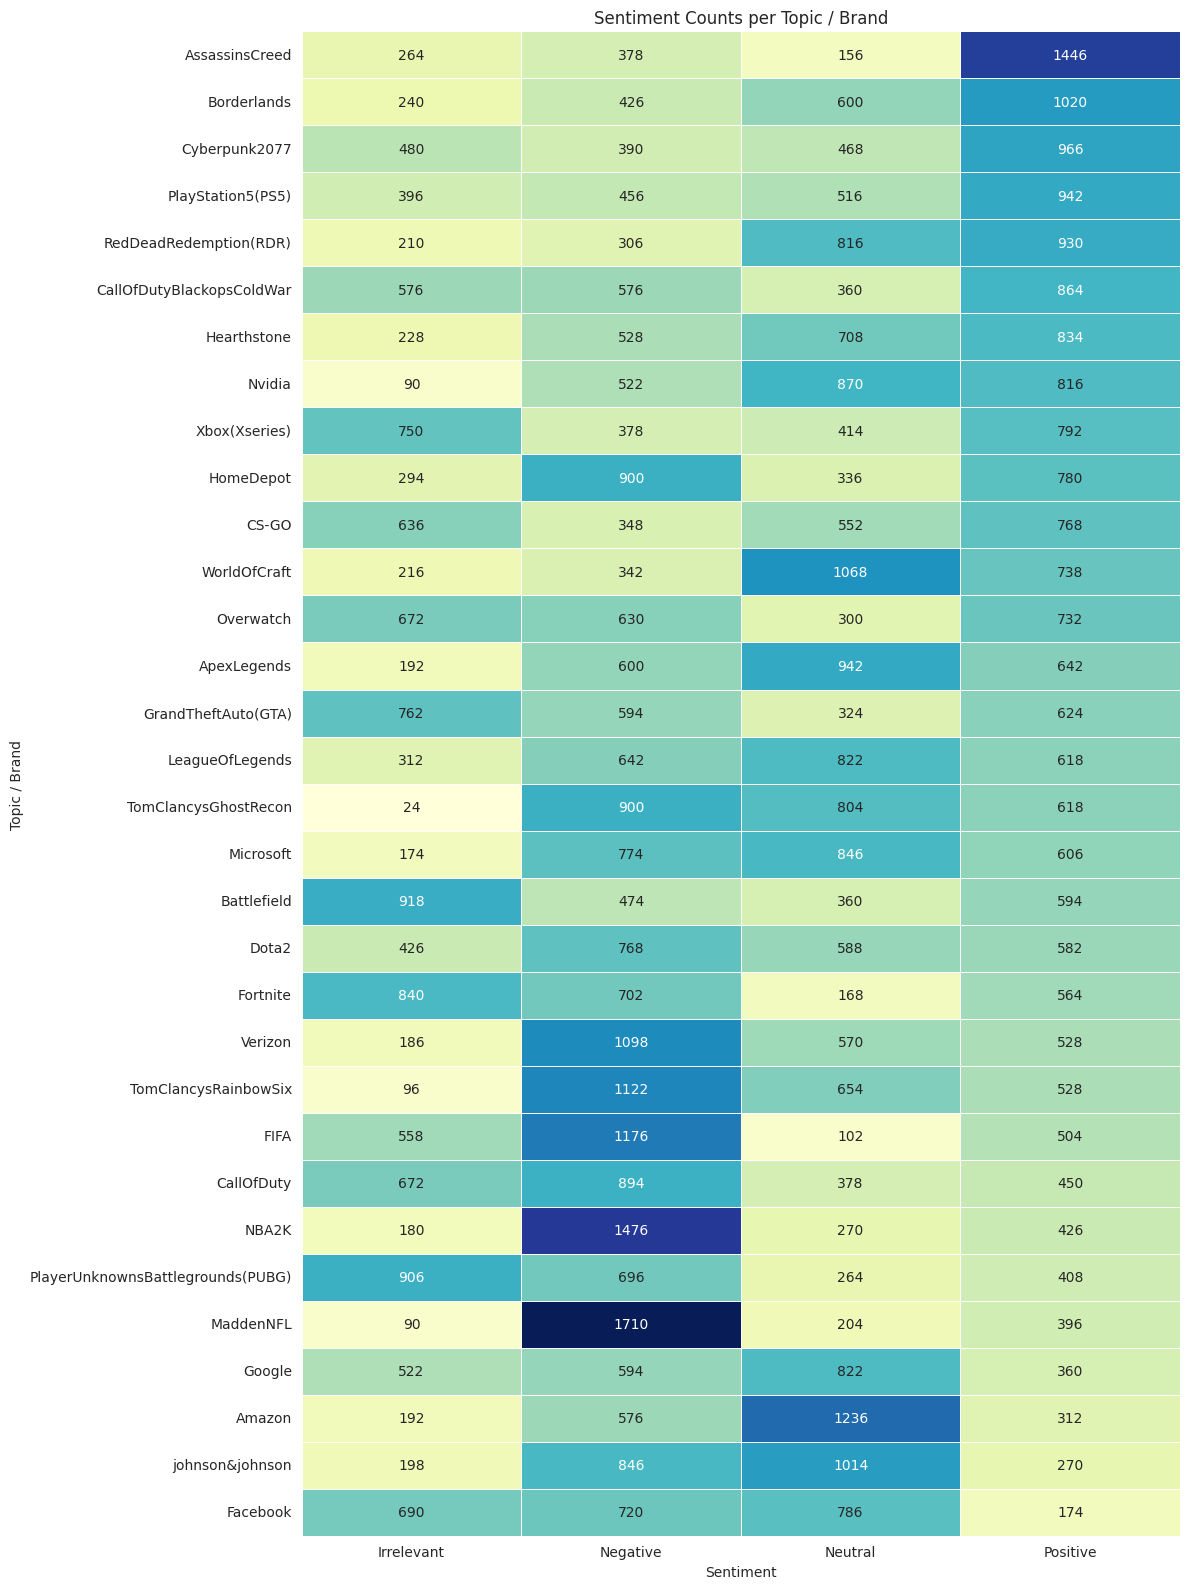

In [ ]:
# ----------------------------- 0. Setup  ------------------------------------
# If you haven't already, install the required libraries ⤵
# !pip install -q pandas matplotlib seaborn transformers torch tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from pathlib import Path
from tqdm import tqdm

sns.set_style("whitegrid")          # nicer plots
plt.rcParams["figure.figsize"] = (10, 6)

DATA_PATH = Path("/content/task4.csv")   # <-- change if needed
HAS_HEADER = False                      # True if your file already has column names

# ----------------------------- 1. Load data  ---------------------------------
if HAS_HEADER:
    df = pd.read_csv(DATA_PATH, encoding="utf-8", on_bad_lines="skip")
else:
    df = pd.read_csv(
        DATA_PATH,
        header=None,
        names=["id", "topic", "sentiment", "text"],
        encoding="latin-1",
        on_bad_lines="skip",
    )

# Keep only what we need
df = df[["topic", "sentiment", "text"]].copy()

# ----------------------------- 2. Clean text ---------------------------------
def basic_clean(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower().strip()
    s = " ".join(s.split())            # squash whitespace
    return s

df["clean_text"] = df["text"].astype(str).apply(basic_clean)

# ----------------------------- 3. Sentiment inference (if needed) -----------
if df["sentiment"].isna().all() or (df["sentiment"] == "").all():
    print("No sentiment column detected – running transformer model…")
    classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
    # Batch‑process for speed
    sentiments = []
    BATCH = 64
    for i in tqdm(range(0, len(df), BATCH)):
        batch_texts = df["clean_text"].iloc[i : i + BATCH].tolist()
        sentiments.extend(classifier(batch_texts))
    # Map model labels to Positive / Neutral / Negative
    label_map = {"LABEL_2": "Positive", "LABEL_1": "Neutral", "LABEL_0": "Negative"}
    df["sentiment"] = [label_map[r["label"]] for r in sentiments]

# ----------------------------- 4. Aggregate ----------------------------------
summary = (
    df.groupby(["topic", "sentiment"], observed=True)
      .size()
      .unstack(fill_value=0)
      .sort_values(by="Positive", ascending=False)
)

display(summary.head(10))    # top 10 topics by positive mentions

# ----------------------------- 5. Visualisations -----------------------------
# 5a. Overall distribution
plt.figure()
sns.countplot(data=df, x="sentiment", order=["Positive", "Neutral", "Negative"])
plt.title("Overall Sentiment Distribution")
plt.xlabel("")
plt.ylabel("Tweet Count")
plt.tight_layout()
plt.show()

# 5b. Sentiment share by topic – stacked bar of top N topics
TOP_N = 8
top_topics = summary.head(TOP_N).index
stack_data = (
    df[df["topic"].isin(top_topics)]
    .groupby(["topic", "sentiment"])
    .size()
    .unstack(fill_value=0)
    .loc[top_topics]                            # keep ordering
)

stack_data.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title=f"Sentiment Breakdown – Top {TOP_N} Topics/Brands",
)
plt.xlabel("Topic / Brand")
plt.ylabel("Tweet Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# 5c. Heat‑map of sentiment intensity across *all* topics (optional)
plt.figure(figsize=(12, 0.5 * len(summary)))
sns.heatmap(
    summary,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar=False,
)
plt.title("Sentiment Counts per Topic / Brand")
plt.xlabel("Sentiment")
plt.ylabel("Topic / Brand")
plt.tight_layout()
plt.show()
